In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve 
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score, confusion_matrix

from collections import Counter

from helper import clean_churn_df, model_baseline, model_baseline_no_cv, score_model_no_cv, score_model
from helper import split_with_dupe_rows_in_train, rf_no_cv_iterx

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

from sqlalchemy import create_engine

plt.style.use('ggplot')
%matplotlib inline


%config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from sqlid import sql_id
engine = create_engine(sql_id()) #stored my unique SQL identifier in a variable, set 

churn_df = pd.read_sql_query('select * from hr',con=engine)  
churn_df.drop('index', axis=1,inplace=True)

In [20]:
churn_df[churn_df.left == 0].shape[0]/churn_df.shape[0] ## imbalanced dataset with .76 in 1 class

0.7619174611640777

In [21]:
total_dupes = churn_df.duplicated().sum()/churn_df.shape[0]

In [22]:
churn_df['duplicate'] = 0
churn_df['duplicate'][churn_df.duplicated()]=1

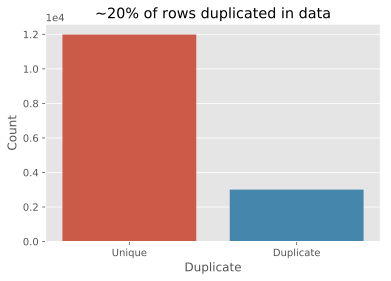

In [23]:
dupe = sns.countplot('duplicate',data=churn_df)
plt.xlabel('Duplicate')
plt.ylabel('Count')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#ax=plt.gca()
#labels = [item.get_text() for item in ax.get_yticklabels() ]
#ax.set_yticks([0,2000,4000,6000,8000,10000,12000],[0,2,4,6,8,10,12])
plt.title('~20% of rows duplicated in data', loc='center');
dupe.set_xticklabels(['Unique','Duplicate']); 

figure = dupe.get_figure()
figure.savefig('images/duplicates.svg',  bbox_inches='tight')

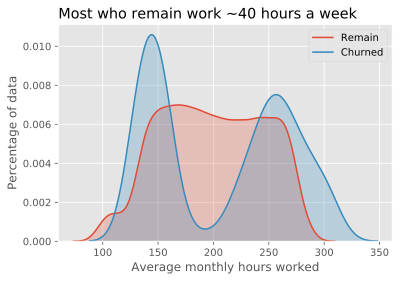

In [24]:
a = sns.kdeplot(churn_df.loc[churn_df.left==0, 'average_montly_hours'], shade=True, label='Remain');
sns.kdeplot(churn_df.loc[churn_df.left==1, 'average_montly_hours'], shade=True, ax=a, label='Churned');
plt.xlabel('Average monthly hours worked')
plt.ylabel('Percentage of data')
plt.title('Most who remain work ~40 hours a week', loc='left');

#code to save file
figure = a.get_figure()
#figure.savefig('timeworked.svg',  bbox_inches='tight')

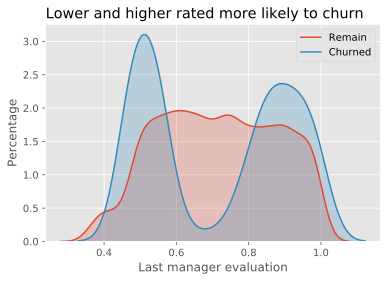

In [25]:
a = sns.kdeplot(churn_df.loc[churn_df.left==0, 'last_evaluation'], shade=True, label='Remain');
sns.kdeplot(churn_df.loc[churn_df.left==1, 'last_evaluation'], shade=True, ax=a, label='Churned');
plt.xlabel('Last manager evaluation')
plt.ylabel('Percentage')
plt.title('Lower and higher rated more likely to churn', loc='left');

figure = a.get_figure()
#figure.savefig('manager_ratings.svg',  bbox_inches='tight')

## Feature importance chart

In [26]:
feat_imp = pd.read_csv('feature_importance.csv')

In [27]:
feat_imp.iloc[:10,:]

,Feature,Importance
0,satisfaction_level,0.987123
1,number_project,0.601475
2,last_evaluation,0.381693
3,average_montly_hours,0.350156
4,time_spend_company,0.302630
5,hours_eval,0.158904
6,support,0.005408
7,high,0.003346
8,low,0.002941
9,technical,0.002332


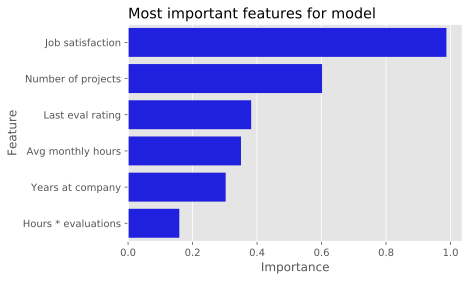

In [40]:
#pal = sns.color_palette("Greens_d", len(data))
a = sns.barplot(x='Importance',y='Feature',data=feat_imp.iloc[:6,:], orient='h', color='blue');
plt.title('Most important features for model', loc='left');
labels2 = ['Job satisfaction', 'Number of projects', 'Last eval rating', 'Avg monthly hours', 'Years at company', 'Hours * evaluations']
a.set_yticklabels(labels2)

figure = a.get_figure()
figure.savefig('images/feature_importance.svg',  bbox_inches='tight')

In [32]:
labels

['satisfaction_level',
 'Testing',
 'last_evaluation',
 'average_montly_hours',
 'time_spend_company',
 'hours_eval']